# TODO:

- Ckeck if dataset needs to be adapted (maybe convert it and upload it to org).
- In case of using this reasoning dataset, add details or fallback for non-reasoning models (another dataset).
- Run training for one epoch.
- Update trackio screenshot.
- Update notebooks' README with new example.

# Supervised Fine-Tuning (SFT) with LoRA/QLoRA using TRL — on a Free Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/fine_tuning_llm_grpo_trl.ipynb)

![trl banner](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/trl_banner_dark.png)

Easily fine-tune Large Language Models (LLMs) or Vision-Language Models (VLMs) with **LoRA** or **QLoRA** using the [**Transformers Reinforcement Learning (TRL)**](https://github.com/huggingface/trl) library built by Hugging Face — all within a **free Google Colab notebook** (powered by a **T4 GPU**.).  

- [TRL GitHub Repository](https://github.com/huggingface/trl) — star us to support the project!  
- [Official TRL Examples](https://huggingface.co/docs/trl/example_overview)  
- [Community Tutorials](https://huggingface.co/docs/trl/community_tutorials)

## Key concepts

- **SFT**: Trains models from example input-output pairs to align behavior with human preferences.
- **LoRA**: Updates only a few low-rank parameters, reducing training cost and memory.
- **QLoRA**: A quantized version of LoRA that enables even larger models to fit on small GPUs.
- **TRL**: The Hugging Face library that makes fine-tuning and reinforcement learning simple and efficient.

Learn how to perform **Supervised Fine-Tuning (SFT)** with **LoRA/QLoRA** using **TRL**.

## Install dependencies

We'll install **TRL** with the **PEFT** extra, which ensures all main dependencies such as **Transformers** and **PEFT** (a package for parameter-efficient fine-tuning, e.g., LoRA/QLoRA) are included. Additionally, we'll install **trackio** to log and monitor our experiments, and **bitsandbytes** to enable quantization of LLMs, reducing memory consumption for both inference and training.

In [ ]:
!pip install -Uq "trl[peft]" trackio bitsandbytes

### Log in to Hugging Face

Log in to your **Hugging Face** account to save your fine-tuned model, track your experiment results directly on the Hub or access gated models. You can find your **access token** on your [account settings page](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load dataset

In this step, we load the [**HuggingFaceH4/Multilingual-Thinking**](https://huggingface.co/datasets/HuggingFaceH4/Multilingual-Thinking) dataset from the Hugging Face Hub using the `datasets` library.  
This dataset focuses on **multilingual reasoning**, where the *chain of thought* has been translated into several languages, including French, Spanish, and German.  
By fine-tuning the selected model on this dataset, it learns to generate reasoning steps in multiple languages—making its thought process more interpretable to non-English speakers.

For efficiency, we'll load only the **training split**:


In [ ]:
from datasets import load_dataset

dataset_name = "HuggingFaceH4/Multilingual-Thinking"
train_dataset = load_dataset("HuggingFaceH4/Multilingual-Thinking", split="train")

In [ ]:
train_dataset[0]

## Load model and configure LoRA/QLoRA

This notebook can be used with two fine-tuning methods. By default, it is set up for **QLoRA**, which includes quantization using `BitsAndBytesConfig`. If you prefer to use standard **LoRA** without quantization, simply comment out the `BitsAndBytesConfig` configuration.

Below, choose your **preferred model**. All of the options have been tested on **free Colab instances**.

In [3]:
# Select one model below by uncommenting the line you want to use 👇
## Qwen
model_id, output_dir = "Qwen/Qwen3-8B", "Qwen3-8B-SFT"                                # ⚠️ ~12.8 GB VRAM
# model_id, output_dir = "Qwen/Qwen2.5-7B-Instruct", "Qwen2.5-7B-Instruct"            # ✅ ~10.8 GB VRAM

## Llama
# model_id, output_dir = "meta-llama/Llama-3.2-3B-Instruct", "Llama-3.2-3B-Instruct"  # ✅ ~4.7 GB VRAM
# model_id, output_dir = "meta-llama/Llama-3.1-8B-Instruct", "Llama-3.1-8B-Instruct"  # ⚠️ ~10.9 GB VRAM

## Gemma
# model_id, output_dir = "google/gemma-3n-E2B-it", "gemma-3n-E2B-it"                  # ❌ Upgrade to a higher tier of colab
# model_id, output_dir = "google/gemma-3-4b-it", "gemma-3-4b-it"                      # ⚠️ image processing error

## Granite
#model_id, output_dir = "ibm-granite/granite-4.0-micro", "granite-4.0-micro"          # ✅ ~3.3 GB VRAM

Let's load the selected model using `transformers`, configuring QLoRA via `bitsandbytes` (you can remove it if doing LoRA). We don't need to configure the tokenizer since the trainer takes care of that automatically.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    attn_implementation="sdpa",                   # Change to Flash Attention if GPU has support
    dtype=torch.float16,                          # Change to bfloat16 if GPU has support
    use_cache=True,                               # Whether to cache attention outputs to speed up inference
    max_length=2048,                              # Maximum context length. Increase if your GPU has enough memory
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,                        # Load the model in 4-bit precision to save memory
        bnb_4bit_compute_dtype=torch.float16,     # Data type used for internal computations in quantization
        bnb_4bit_use_double_quant=True,           # Use double quantization to improve accuracy
        bnb_4bit_quant_type="nf4"                 # Type of quantization. "nf4" is recommended for recent LLMs
    )
)

The following cell defines LoRA (or QLoRA if needed). When training with LoRA/QLoRA, we use a **base model** (the one selected above) and, instead of modifying its original weights, we fine-tune a **LoRA adapter** — a lightweight layer that enables efficient and memory-friendly training. The **`target_modules`** specify which parts of the model (e.g., attention or projection layers) will be adapted by LoRA during fine-tuning.

In [5]:
from peft import LoraConfig

# You may need to update `target_modules` depending on the architecture of your chosen model.
# For example, different LLMs might have different attention/projection layer names.
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
)

## Train model

We'll configure **SFT** using `SFTConfig`, keeping the parameters minimal so the training fits on a free Colab instance. You can adjust these settings if more resources are available. For full details on all available parameters, check the [TRL SFTConfig documentation](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [6]:
from trl import SFTConfig

training_args = SFTConfig(
    # Training schedule / optimization
    learning_rate=2e-4,                   # Learning rate for the optimizer
    #num_train_epochs=1,                  # Number of full dataset passes. For shorter training, use `max_steps` instead
    #max_steps=2,
    per_device_train_batch_size=2,        # Batch size per GPU/CPU
    gradient_accumulation_steps=8,        # Gradients are accumulated over multiple steps → effective batch size = 2 * 8 = 16
    warmup_steps=5,                       # Gradually increase LR during first N steps
    optim="adamw_8bit",                   # Optimizer (use `adamw_torch` if not using 8-bit quantization)
    gradient_checkpointing=True,          # Save memory during training by recomputing activations in the backward pass

    # Logging / reporting
    logging_steps=1,                      # Log training metrics every N steps
    report_to="trackio",                  # Experiment tracking tool
    output_dir=output_dir,                # Where to save model checkpoints and logs

    # Hub integration
    push_to_hub=True,                     # Automatically push the trained model to the Hugging Face Hub
                                          # The model will be saved under your Hub account in the repository named `output_dir`
)

Configure the SFT Trainer. We pass the previously configured `training_args`. We don't use eval dataset to mantain memory usage low but you can configure it.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=peft_config
)

Show memory stats before training

In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

And train!

In [ ]:
trainer_stats = trainer.train()

Show memory stats after training

In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

The training procedure generates both standard training logs and **trackio** logs, which help us monitor the training progress. Example outputs would look like the following:

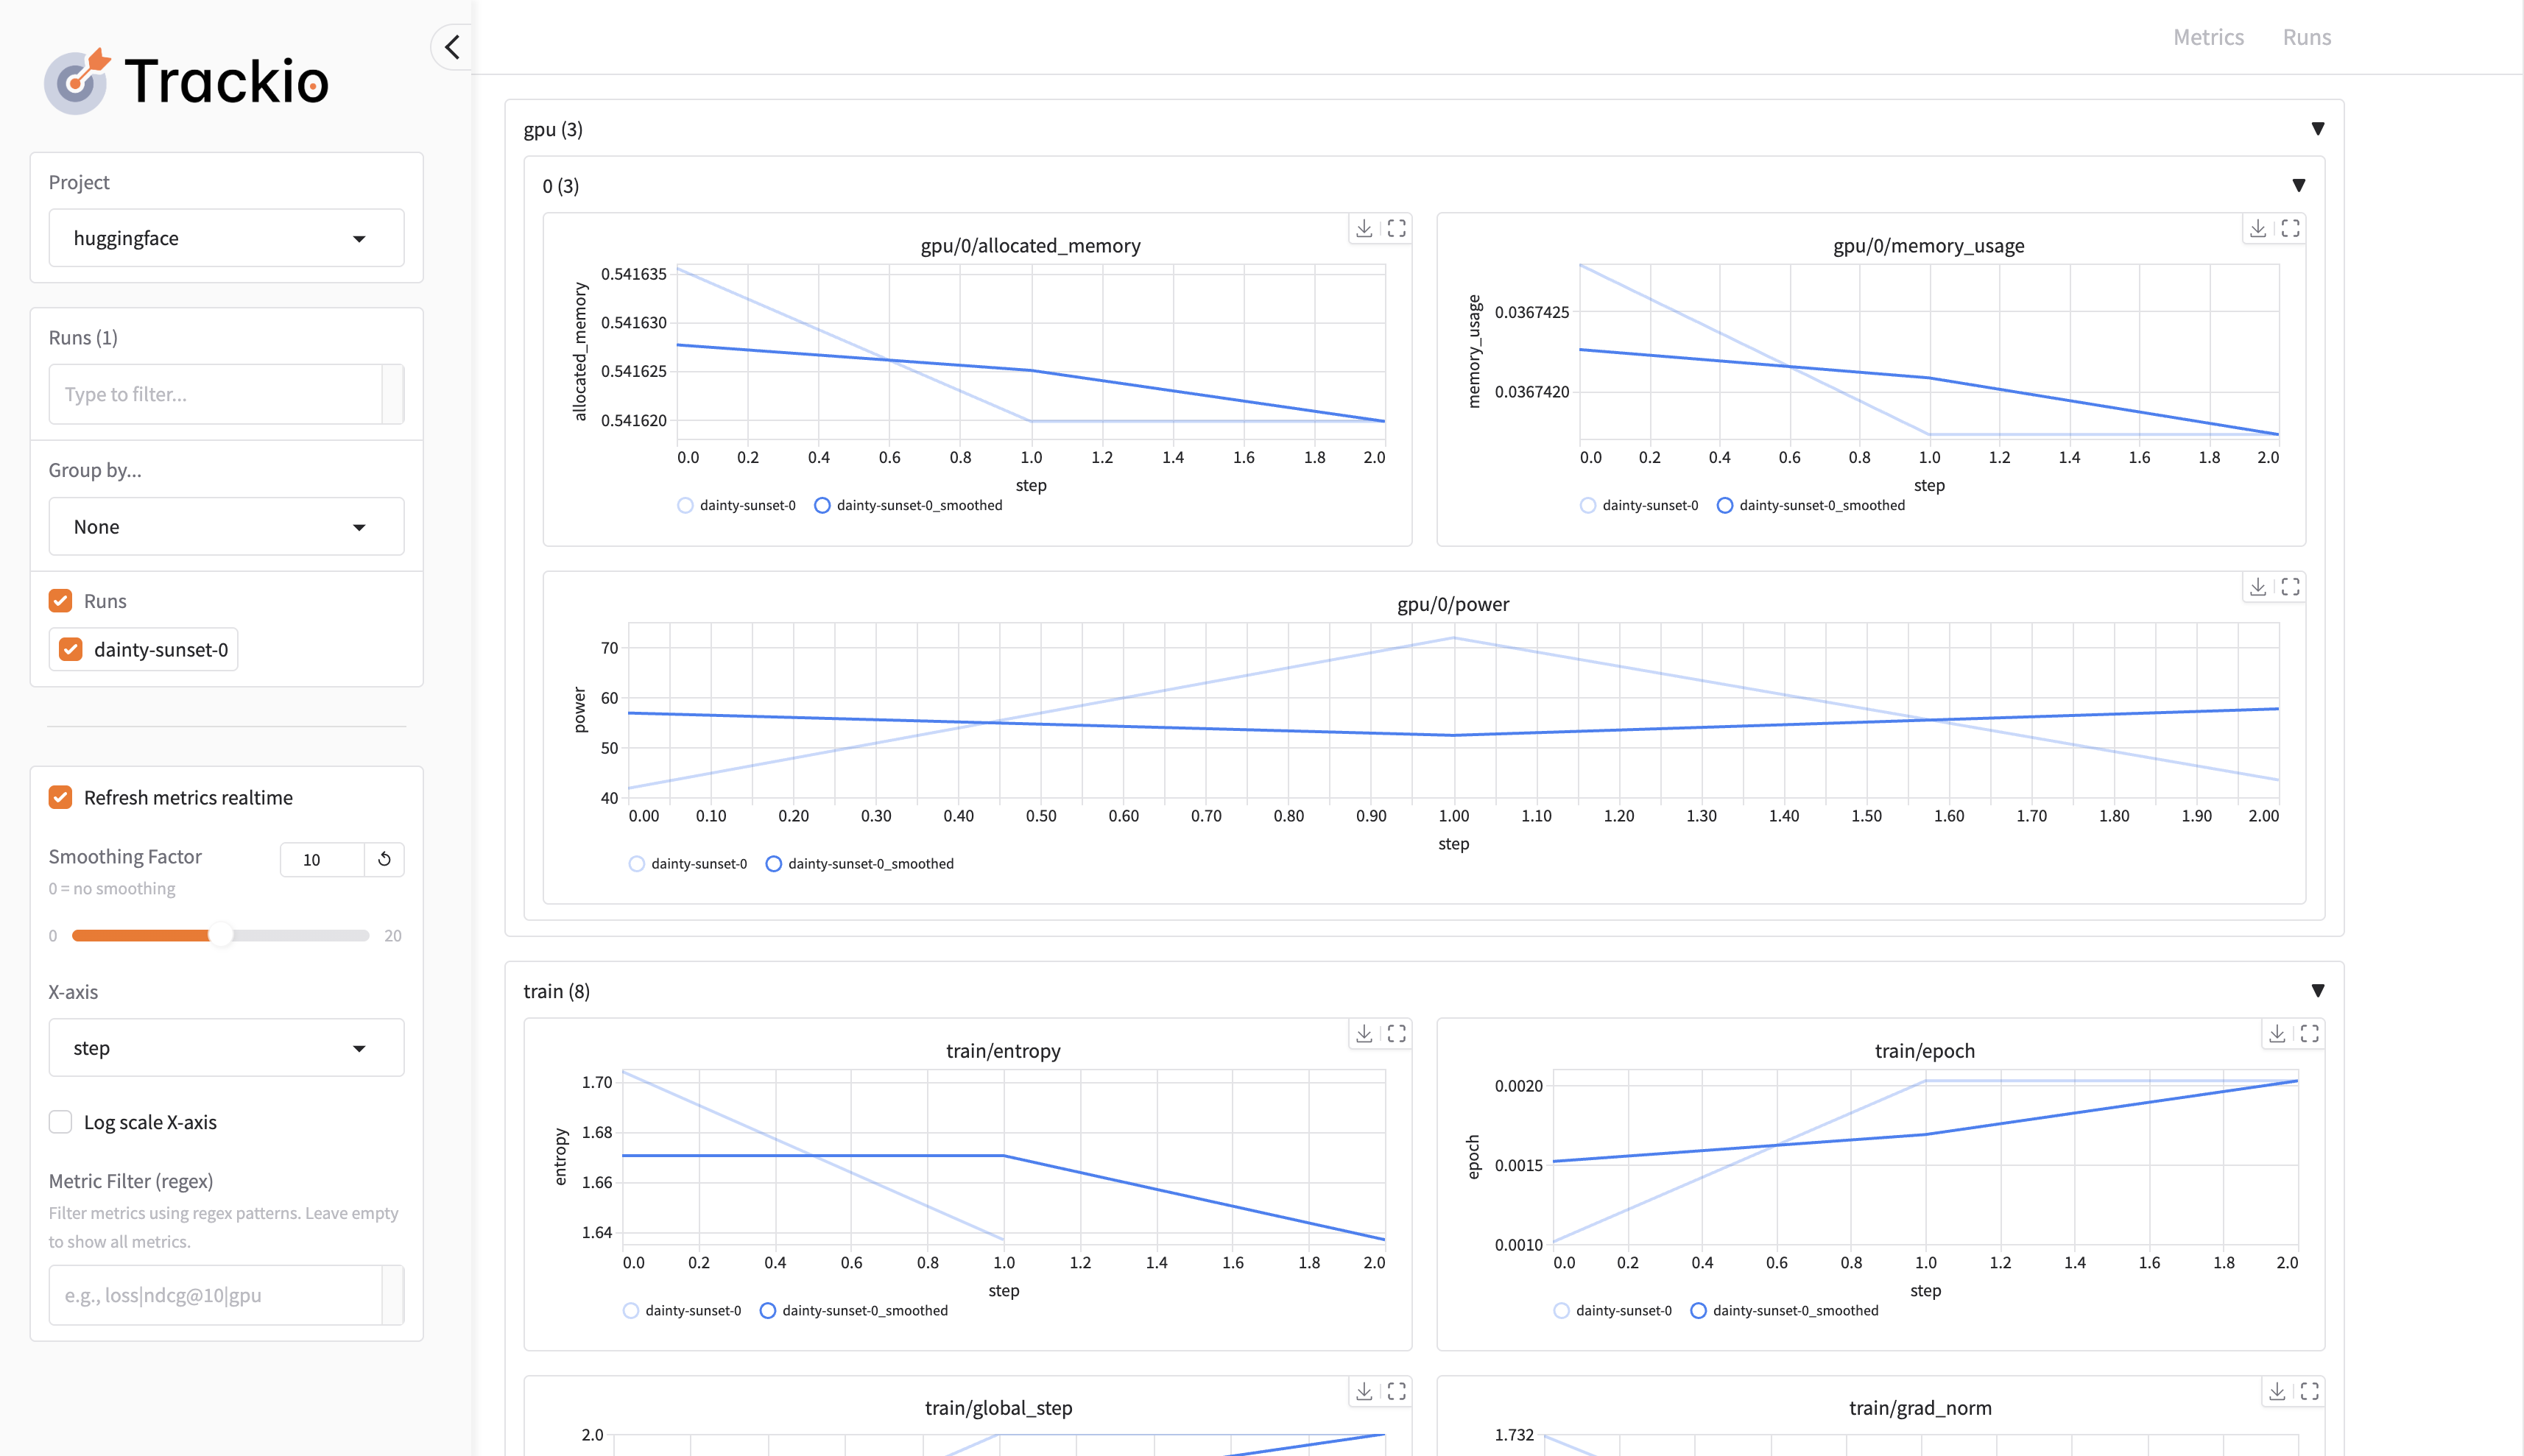

## Saving fine tuned model

In this step, we save the fine-tuned model both **locally** and to the **Hugging Face Hub** using the credentials from your account.

In [ ]:
trainer.save_model(output_dir)
trainer.push_to_hub(dataset_name=dataset_name)

## Load the fine-tuned model and run inference

Now, let's test our fine-tuned model by loading the **LoRA/QLoRA adapter** and performing **inference**. We'll start by loading the **base model**, then attach the adapter to it, creating the final fine-tuned model ready for evaluation.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model = model_id
adapter_model = f"sergiopaniego/{output_dir}" # Replace with your HF username or organization

model = AutoModelForCausalLM.from_pretrained(base_model, dtype="auto", device_map="auto")
model = PeftModel.from_pretrained(model, adapter_model)

tokenizer = AutoTokenizer.from_pretrained(base_model)

In [21]:
messages = [
    {
        "role": "user",
        "content": "What is the capital of Spain?",
    },
]

In [ ]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=500
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

## Inference and Serving with vLLM

You can use Transformer models with **vLLM** to serve them in real-world applications. Learn more [here](https://blog.vllm.ai/2025/04/11/transformers-backend.html).

In [ ]:
!pip install -qU vllm

### Push Merged Model (for LoRA or QLoRA Training)

To serve the model via **vLLM**, the repository must contain the merged model (base model + LoRA adapter). Therefore, you need to upload it first.

In [ ]:
model_merged = model.merge_and_unload()

save_dir = f"{output_dir}-merged"

model_merged.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

In [ ]:
model_merged.push_to_hub(f"sergiopaniego/{output_dir}-merged") # Replace with your HF username or organization
tokenizer.push_to_hub(f"sergiopaniego/{output_dir}-merged") # Replace with your HF username or organization

### Performing Inference with vLLM

Use **vLLM** to run your model and generate text efficiently in real-time. This allows you to test and deploy your fine-tuned models with low latency and high throughput.

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
import torch

llm = LLM(
    model=f"sergiopaniego/{output_dir}-merged", # Replace with your HF username or organization
    model_impl="transformers",                  # Select the transformers model implementation
    max_model_len=2048,                         # Reduced for efficiency
    dtype=torch.float16
)
hf_tokenizer = AutoTokenizer.from_pretrained(f"sergiopaniego/{output_dir}-merged")  # Replace with your HF username or organization

messages = [
    {
        "role": "user",
        "content": "What is the capital of Spain?",
    },
]

prompt = hf_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

outputs = llm.generate(
    {"prompt": prompt},
    sampling_params=SamplingParams(max_tokens=500),
)

for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)